In [1]:
#Chapter focus:
#1. Make predictions based on majority voting
#2. Use bagging the reduce overfitting by drawing random combinations of the training set with repetition
#3. Apply boosting to build powerful models from weak learners that learn from their mistakes

#Ensemble methods:
#-Combine different classifiers into a meta-classifier that has better generalization performance
#-Most popular: majority voting
# -> select the class label that has been predicted by the majority of classifiers
# -> Binary class settings only
# -> Multi-class settings? Plurality voting
#-Techniques:
# -> build from different classification algorithms
# -> use the same base classification algorithm, fitting different subsets of the training set
#-Why ensemble methods can work better than individual classifiers?
# -> the error probability of an ensemble of base classifiers is a probability mass function of a binomial distribution
# -> if many people say yes, then probably it is more true than a single person says yes.

#Compare an idealistic ensemble classifier to a base classifier over a range of different base error rates

from scipy.special import comb
import math

#implement the ensemble_error function
def ensemble_error(n_classifier,error):
    k_start = int(math.ceil(n_classifier/2.))
    probs = [comb(n_classifier,k)*error**k*(1-error)**(n_classifier-k)
             for k in range(k_start,n_classifier+1)]
    return sum(probs)

#Test
ensemble_error(n_classifier=11,error=0.25)

0.03432750701904297

In [2]:
#Visualize the relationship between ensemble and base errors in a line graph
import numpy as np
import matplotlib.pyplot as plt

error_range = np.arange(0.0,1.01,0.01)
ens_errors = [ensemble_error(n_classifier=11,error=error)
              for error in error_range]

#Plot the line of ensemble errors
plt.plot(error_range,ens_errors,label='Ensemble error',linewidth=2)

#Plot the line of base error
plt.plot(error_range,error_range,linestyle='--',label='Base error',linewidth=2)

#Legend stuff
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

#As long as the base classifiers perform better than random guessing (error rate < 0.5)
#Ensemble always performs better than individual base classifier

<Figure size 640x480 with 1 Axes>

In [3]:
#Combining classifiers via majority vote

#Implementing a simple majority vote classifier
#Combine different classification algorithms associated with individual weights for confidence
#Goal: build a stronger meta-classifier that balances out the individual classifiers' weaknesses on a particular dataset

#Illustration of the weighted majority vote:
np.argmax(np.bincount([0,0,1],weights=[0.2,0.2,0.6]))



1

In [4]:
#Illustration of the weighted majority vote based on class probability

ex = np.array([[0.9,0.1],
               [0.8,0.2],
               [0.4,0.6]])
p = np.average(ex,axis=0,weights=[.2,.2,.6])
p

array([0.58, 0.42])

In [5]:
np.argmax(p)

0

In [6]:
from sklearn.base import BaseEstimator #inherit some base functionalities
from sklearn.base import ClassifierMixin #inherit some base functionalities
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six #make the class compatible with Python 2.6
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator,ClassifierMixin): #inheritance
    """A Majority Vote Ensemble Classifier
    
    Parameters
    ------------
    classifiers: array-like, shape = [n_classifiers]
        Different classifiers for the ensemble
        
    vote: str, {'classlabel','probability'}(default='label')
        If 'classlabel' the prediction is based on the armax of class labels.
        Else if 'probability', the argmax of sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).
        
    weights: array-like, shape = [n_classifiers], optional (default = None)
        If a list of `int` or `float` values are provided, the classifiers
        are weighted by importance; Uses uniform weights if `weights=None
    """
    
    def __init__(self,classifiers,vote='classlabel',weights=None):
        self.classifiers = classifiers
        self.named_classifiers={key:value 
                                for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self,X,y):
        """Fit classifiers.
        
        Parameters
        ------------------
        X:{array-like, sparse matrix}, shape=[n_samples,n_features]
            Matrix of training samples
            
        y: array-like, shape=[n_samples]
            Vector of target class labels
            
        Returns
        ----------------
        self: object
        """
        #Exception handling
        if self.vote not in ('probability','classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)" % self.vote)
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('NUmber of classifiers and weight must be equal;'
                             'got %d weights, %d classifiers'
                             % (len(self.weights),len(self.classifiers)))
        
        #Use LabelEncoder to ensure class labels start with 0, which
        #is important for np.argmax call in self.predict
        self.labelenc_=LabelEncoder()
        self.labelenc_.fit(y)
        self.classes_ = self.labelenc_.classes_
        self.classifiers_ = []
        
        #fit the training sets with different classifiers
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X,self.labelenc_.transform(y)) #without clone, maybe only return data not a classifier???
            self.classifiers_.append(fitted_clf)
            
        return self
    
    def predict(self,X):
        """Predict class labels for X.
        
        Parameters
        -----------
        X: {array-like, sparse matrix}, shape = [n_samples, n_features]
        
        Returns
        -----------
        maj_vote: array-like, shape = [n_samples]
        
        """
        
        if self == 'probability':
            maj_vote = np.argmax(self.predict_proba(X),axis=1)
        else: # 'classlabel' vote
            # Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X) #asarray convert structured data into an ndarray
                                      for clf in self.classifiers_]).T #noted that it is transposed
            #Apply the lambda function along the column
            #each column stands for each sample, 
            #lambda function find the weighted mode of the prediction
            #as a result, each sample has a major_vote result
            
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x,weights=self.weights)),
                                          axis=1,arr=predictions)
        #convert the labelencoded code back to labels
        maj_vote = self.labelenc_.inverse_transform(maj_vote)
        
        return maj_vote
        
    def predict_proba(self,X):
        """Predict class probabilities for X
        
        Parameters
        -----------
        X: {array-like, sparse matrix}, shape=[n_samples, n_features]
            Training vectors, where n_samples is the number of samples and n_features i the number of features.
            
        Returns
        -----------
        avg.proba: array-like, shape=[n_samples, n_classes]
            Weighted averge probability for each class per sample.
        """
        #Calculate the proba for each label in each sample
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_]) #no transpose
        #column: prob each label, row: prob
        #apply to row, get
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self,deep=True):
        """Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier,self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name,key)] = value
            return out
            
        

In [7]:
#Using the majority voting principle to make predictions

#load the Iris dataset from scikit-learn's dataset module
#only select two features, sepal width and petal length 
#to make the classification task more challenging for illustration purpose

#Although MajorityVoteClassifier generalises to multiclass problems,
#we will only classify flower samples from the Iris-versicolor and Iris-virginica classes

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#load the data
iris = datasets.load_iris()
#only classify flower samples from the Iris-versicolor and Iris-virginica classes
#only select two features, sepal width and petal length 
X,y = iris.data[50:,[1,2]],iris.target[50:]
#encode the label
le = LabelEncoder()
y = le.fit_transform(y)

#split the Iris samples into 50% training and 50% test data
X_train, X_test, y_train, y_test = \
    train_test_split(X,y,test_size=0.5,random_state=1,stratify=y)


In [8]:
#Train 3 different classifiers:
#1. Logistic regression classifier
#2. Decision tree classifier
#3. k-nearest neighbors classifier

#evaluate the performance of each classifier via 10-fold cross-validation on the training dataset
#before combining them in to an ensemble classifier

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

import numpy as np
clf1 = LogisticRegression(penalty='l2',C=0.001,random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1,criterion='entropy',random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1,p=2,metric='minkowski')

#logistic regression is not scale invariant, pipeline to standardize scale
pipe1 = Pipeline([['sc',StandardScaler()],['clf',clf1]])
#KNN is not scale invariant, pipeline to standardize scale
pipe3 = Pipeline([['sc',StandardScaler()],['clf',clf3]])
#But decision tree is scale invariant, so no need standardize scale

clf_labels = ['Logistic regression','Decision tree','KNN']

print('10-fold cross validation: \n')
for clf, label in zip([pipe1,clf2,pipe3],clf_labels):
    scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc')
    print("ROC_AUC: %.2f (+/- %.2f) [%s]" % (scores.mean(), scores.std(),label))
    
#the output shows that the predictive performances of the individual classifiers are almost equal:



10-fold cross validation: 

ROC_AUC: 0.87 (+/- 0.17) [Logistic regression]
ROC_AUC: 0.89 (+/- 0.16) [Decision tree]
ROC_AUC: 0.88 (+/- 0.15) [KNN]


In [9]:
#Combine the individual classifiers for major rule voting
mv_clf = MajorityVoteClassifier(classifiers=[pipe1,clf2,pipe3])
clf_labels += ['Majority voting']

all_clf = [pipe1,clf2,pipe3,mv_clf]

for clf,label in zip(all_clf,clf_labels):
    scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc')
    print("ROC_AUC: %.2f (+/- %.2f) [%s]" % (scores.mean(), scores.std(),label))

ROC_AUC: 0.87 (+/- 0.17) [Logistic regression]
ROC_AUC: 0.89 (+/- 0.16) [Decision tree]
ROC_AUC: 0.88 (+/- 0.15) [KNN]
ROC_AUC: 0.94 (+/- 0.13) [Majority voting]


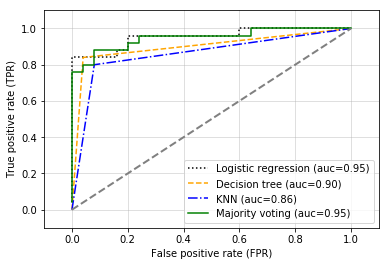

In [10]:
#Evaluating and tuning the ensemble classifier

#compute the ROC curves from the test set
#Note that the test set is not to used for model slection
#merely to report an unbiased estimate of the generalization performance of a classified system

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black','orange','blue','green']
linestyles = [':','--','-.','-']

for clf,label,clr,ls in zip(all_clf,clf_labels,colors,linestyles):
    #assuming the label of the possitive class is 1
    y_pred = clf.fit(X_train,y_train).predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,y_score=y_pred)
    roc_auc = auc(x=fpr,y=tpr)
    
    plt.plot(fpr,tpr,color=clr,linestyle=ls,label='%s (auc=%.2f)' % (label,roc_auc))
    
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],linestyle='--',color='gray',linewidth=2)

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])

plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show()


/home/Rex/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


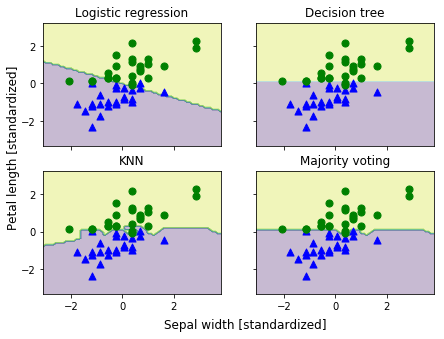

In [11]:
#Visualize the decision region of the ensemble classifier

#Although it is not necessary to standardize the training features prior to model fitting
#because our logistic regression and k-nearest neighbors pipelines will automatically take care of it
#we will standardize the training set so that the decision regions of the decision tree will be on the same scale for visual purposes

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

from itertools import product

all_clf = [pipe1, clf2, pipe3, mv_clf]
x_min = X_train_std[:,0].min()-1
x_max = X_train_std[:,0].max()+1
y_min = X_train_std[:,1].min()-1
y_max = X_train_std[:,1].max()+1

#form meshgrid, to plot contour plot (for visualizing decision region)
xx, yy = np.meshgrid(np.arange(x_min,x_max,0.1),
                     np.arange(y_min,y_max,0.1))

#form subplots
f, axarr = plt.subplots(nrows=2,ncols=2,sharex='col',sharey='row',figsize=(7,5))

for idx, clf, tt in zip(product([0,1],[0,1]), all_clf,clf_labels):
    
    clf.fit(X_train_std,y_train)
    
    #ravel (flatten) xx and yy, np.c_ match each xx to each yy
    #np.c_[xx.ravel(),yy.ravel()] is like [x,y], while x is the regressor, y is the regressand
    Z =clf.predict(np.c_[xx.ravel(),yy.ravel()]) #combine two vectors/matrices by column
    
    #reshape Z so that it can be plotted as a contour plot
    Z = Z.reshape(xx.shape)
    axarr[idx[0],idx[1]].contourf(xx,yy,Z,alpha=0.3)
    
    #compare the decision region and the training data
    axarr[idx[0],idx[1]].scatter(X_train_std[y_train==0,0],
                                 X_train_std[y_train==0,1],
                                 c='blue',
                                 marker='^',
                                 s=50)
    axarr[idx[0],idx[1]].scatter(X_train_std[y_train==1,0],
                                 X_train_std[y_train==1,1],
                                 c='green',
                                 marker='o',
                                 s=50)
    #title of each subplot
    axarr[idx[0],idx[1]].set_title(tt)

#legend
plt.text(-3.5,-5.,s='Sepal width [standardized]',ha='center',va='center',fontsize=12)
plt.text(-12.5,4.5,s='Petal length [standardized]',ha='center',va='center',fontsize=12,rotation=90)

plt.show()

In [12]:
#Call the get_params method
#Get a basic idea of how we can access the indivdual parameters inside a GridSearch object

mv_clf.get_params()

{'pipeline-1': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'pipeline-2': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=No

In [13]:
#Based on the values returned by the get_params method,
#we noe know how to access the individual classifier's attributes(?????)

#Tune the inverese regularization parameter C of the logistic regression classifier
#and the decision tree depth
#via a grid search

from sklearn.model_selection import GridSearchCV

params = {'decisiontreeclassifier__max_depth':[1,2],
          'pipeline-1__clf__C':[0.001,0.1,100]}

grid = GridSearchCV(estimator=mv_clf,param_grid=params,cv=10,scoring='roc_auc')

grid.fit(X_train,y_train)

#after the grid search has completed
#we can print the different hyperparameter value combinations and 
#the average ROC AUC computed via 10-fold cross-validation

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%.3f +/- %.2f %r" % (grid.cv_results_['mean_test_score'][r],
                                grid.cv_results_['std_test_score'][r]/2.0,
                                grid.cv_results_['params'][r]))
    

0.933 +/- 0.07 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.973 +/- 0.04 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.973 +/- 0.04 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100}


In [14]:
#print the best cross-validation score and the corresponding parameters

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

#As we can see, lower regularization strength, better cross-validation result
#tree depth seems to be irrelevent to the performance

#Noted it is a bad practice to use the test dataset more than onece for model evaluation

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100}
Accuracy: 0.97


Note
By default, the default setting for refit in GridSearchCV is True (i.e., GridSeachCV(..., refit=True)), which means that we can use the fitted GridSearchCV estimator to make predictions via the predict method, for example:

grid = GridSearchCV(estimator=mv_clf, 
                    param_grid=params, 
                    cv=10, 
                    scoring='roc_auc')
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

In addition, the "best" estimator can directly be accessed via the best_estimator_ attribute.


In [15]:
grid.best_estimator_.classifiers

[Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False)]]),
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=1, p=2,
            weights='u

In [16]:
mv_clf = grid.best_estimator_

In [17]:
mv_clf.set_params(**grid.best_estimator_.get_params())

MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', rand...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])],
            vote='classlabel', weights=None)

In [18]:
mv_clf

MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', rand...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])],
            vote='classlabel', weights=None)

In [24]:
#Bagging: bootstrap aggregating
#draw bootstrap samples (random samples with replacements) from the initial training set

#Random forests: special case of bagging, not only random sample subsets but also random feature subsets when fitting the individual decision tree

#Create a more complex classification problem using the Wine dataset

#we only consider the Wine classes 2 and 3:
#select two features: Alcohol and OD280/OD315 of diluted wines

import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

#drop 1 class
#we only consider the Wine classes 2 and 3:
df_wine = df_wine[df_wine['Class label'] != 1]

#select two features: Alcohol and OD280/OD315 of diluted wines
y = df_wine['Class label'].values
X = df_wine[['Alcohol','OD280/OD315 of diluted wines']].values


#encode the class labels into binary format
#and split the dataset into 80% training and 20% test sets respectively
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=1, stratify=y)

#BaggingClassifier is already implemented in scikit-learn
#import from the ensemble submodule

#Here, we will use an unpruned decision tree as the base classifier
#create an ensemble of 500 decision trees fit on different bootstrap samples of the training dataset

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion = 'entropy',
                              max_depth = None,
                              random_state = 1)

bag = BaggingClassifier(base_estimator = tree,
                        n_estimators = 500,
                        max_samples = 1.0,
                        max_features = 1.0,
                        bootstrap = True,
                        bootstrap_features = False,
                        n_jobs = 1,
                        random_state = 1)


#Calculate the accuracy socre of the prediction on the training and test data set
#to compare the performance of the bagging classifier to the performance of a single unpruned decision tree

from sklearn.metrics import accuracy_score

tree = tree.fit(X_train,y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train,tree_test))


bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
#we can see that the bagging classifier has a slightly better generalization performance
print('Bagging train/test accuracies %.3f/%.3f'
      %(bag_train,bag_test))

Decision tree train/test accuracies 1.000/0.833
Bagging train/test accuracies 1.000/0.917


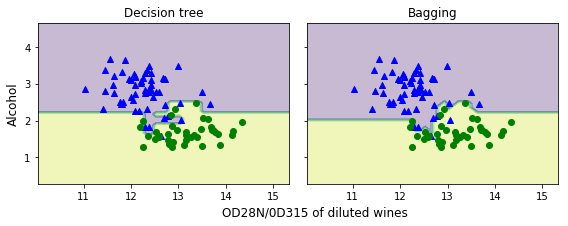

In [27]:
#Compare the decision regions
#between the decision tree and the bagging classifier

import numpy as np
import matplotlib.pyplot as plt

#preparing the meshgrid
x_min = X_train[:,0].min()-1
x_max = X_train[:,0].max()+1
y_min = X_train[:,1].min()-1
y_max = X_train[:,1].max()+1

xx, yy = np.meshgrid(np.arange(x_min,x_max,0.1),
                     np.arange(y_min,y_max,0.1))

#setting the subplots
f, axarr = plt.subplots(nrows = 1, ncols = 2,
                       sharex = 'col',
                       sharey = 'row',
                       figsize = (8,3))

#plotting the data on the subplots
for idx, clf, tt in zip([0,1],[tree,bag],['Decision tree','Bagging']):
    clf.fit(X_train,y_train)
    
    Z = clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axarr[idx].contourf(xx,yy,Z,alpha=.3)
    axarr[idx].scatter(X_train[y_train==0,0],
                       X_train[y_train==0,1],
                       c = 'blue', marker = '^')
    axarr[idx].scatter(X_train[y_train==1,0],
                       X_train[y_train==1,1],
                       c = 'green', marker = 'o')
    axarr[idx].set_title(tt)
    
#legend stuff
axarr[0].set_ylabel('Alcohol',fontsize = 12)
plt.text(10.2,-0.5,s='OD28N/0D315 of diluted wines',
         ha = 'center', va = 'center', fontsize = 12)

plt.tight_layout()
plt.show()

#We only looked at a very simple bagging example
#more complex classification tasks and a dataset's high dimensionality can easily lead to overfitting in single decision tree
#bagging can play to its strength.

#Noted that bagging is good at reduce the variance of a model,
#but cannot reduce the bias

#Bagging + emsemble

In [30]:
#Leveraging weak learners via adaptive boosting

#boosting and AdaBoost (Adaptive Boosting)

#Boosting:
# The ensample consist of very simple base classifiers, also often referred to as Weak learner
# which often only have a slight performance advantage over random guessing
# boosting is to focuse on the training samples that are hard to classify
# to let the weak learners subsequently learn from misclassified training samples to improve the performance of the ensemble
# theoretically, decrease in bias and variance
# but AdaBoost is also known for their high variance (overfit)

#How boosting works?
# the initial formulation of boosting: uses random subsets of training samples drawn from the training dataset without replacement
# 1. draw a random subset of training samples d_1 without replacement from training set D to train a weak learner C_1
# 2. draw a second random training subsets d_2 without replacement from the training set and add 50% of the samples that were previously misclassified to train a weak learner C_2
# 3. find the training samples d_3 in training set D, which C_1 and C_2 disagree upon, to train a third weak learner C_3
# 4. combine the weak learners C_1, C_2, and C_3 via majority voting.

#AdaBoost
# use the complete training set to train the weak learners
# where the training samples are reweighted in each iteration to build a strong classifier
# that learns from the mistake of the previous weak learners in the ensemble.
# combine the three weak learners trained on different reweighted training subsets by a weighted marjority vote

#AdaBoost Steps:
# 1. set the weight vector w to uniform weights
# 2. For j in m boosting rounds:
#    a. Train a weighted weak learner
#    b. Predict class labels
#    c. Compute weighted error rate
#    d. Compute coefficient
#    e. Update weights
#    f. Normalize weights to sum to 1
# 3. Compute the final prediction

#Applying AdaBoost using scikit-learn

# use the same Wine subset that we used in the previous section to train the bagging meta-classifier
# via the base_estimator attribute, we will train the AdaBoostClassifier on 500 decision tree stumps

from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy',max_depth=1,random_state=1)
ada = AdaBoostClassifier(base_estimator=tree,n_estimators=500,learning_rate=0.1,random_state=1)

tree = tree.fit(X_train,y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train,y_train_pred)
tree_test = accuracy_score(y_test,y_test_pred)

print('Decision tree train/test accuracies %.3f/%.3f' %(tree_train,tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test,y_test_pred)

print('AdaBoost train/test accuracies %.3f/%.3f'
      % (ada_train,ada_test))

#AdaBoost shows a slightly improved test set performance compared to the decision tree stump
# but also introduce additional variance - a higher gap between training and test performance

#But noted that is a bad practice to select a model based on the repeated usage of the test set
# the estimate may be over-optimistic

Decision tree train/test accuracies 0.916/0.875
AdaBoost train/test accuracies 1.000/0.917


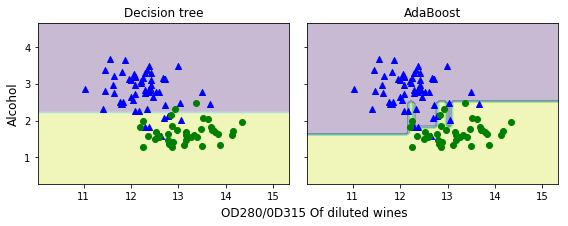

In [33]:
#Check the decision regions:


x_min, x_max = X_train[:,0].min()-1, X_train[:,0].max()+1
y_min, y_max = X_train[:,1].min()-1, X_train[:,1].max()+1

xx, yy = np.meshgrid(np.arange(x_min,x_max,0.1),
                     np.arange(y_min,y_max,0.1))

f, axarr = plt.subplots(nrows = 1, ncols = 2,
                       sharex = 'col',sharey = 'row', figsize = (8,3))

for idx, clf, tt in zip([0,1],
                        [tree, ada],
                        ['Decision tree','AdaBoost']):
    clf.fit(X_train,y_train)
    
    Z = clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axarr[idx].contourf(xx,yy,Z,alpha=.3)
    axarr[idx].scatter(X_train[y_train==0,0],
                       X_train[y_train==0,1],
                       c = 'blue', marker = '^')
    axarr[idx].scatter(X_train[y_train==1,0],
                       X_train[y_train==1,1],
                       c = 'green',marker = 'o')
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol', fontsize = 12)

plt.text(10.2,-0.5, s = 'OD280/0D315 Of diluted wines',
         ha = 'center', va = 'center', fontsize = 12)

plt.tight_layout()
plt.show()